In [371]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import os

ROOT = Path("")

In [121]:
df = pd.read_csv("../../data/all_results.csv")

In [209]:
df.head()

,Unnamed: 0,name,dataset,attack,setup,eps,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta
0,0,NN_tune_trainable_a17ed_00710_710_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.0010,0.9,sgd,0.0001,674695,0.067,0.979,0.378464,0.3051,0.6739
1,1,NN_tune_trainable_a17ed_00686_686_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,relu,0.0001,0.9,adam,0.0001,486815,0.054,0.984,0.056045,0.8454,0.1386
2,2,NN_tune_trainable_a17ed_01002_1002_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,relu,0.0001,0.9,sgd,0.0001,162638,2.301,0.113,0.230108,0.1135,-0.0005
3,3,NN_tune_trainable_a17ed_00775_775_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_normal,tanh,0.0010,0.9,adam,0.0010,651635,0.134,0.960,0.296555,0.2168,0.7432
4,4,NN_tune_trainable_a17ed_01098_1098_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,relu,0.0010,0.9,sgd,0.0010,361619,2.301,0.113,0.230111,0.1135,-0.0005


In [122]:
for i in range(len(df)):
    df.loc[i, "delta"] = df.loc[i, 'old_acc'] - df.loc[i, "new_acc"]

In [310]:
data = df[df.dataset=="CIFAR10"]
data = data[data.attack=="FGSM"]
data = data[data.setup=="hyp-10-f"]
data = data[data.eps==0.1]

In [311]:
data = data[data.columns[6:]]

In [254]:
data["dropout"] = data["dropout"].astype("category")
data["init_type"] = data["init_type"].astype("category")
data["nlin"] = data["nlin"].astype("category")
data["wd"] = data["wd"].astype("category")
data["lr"] = data["lr"].astype("category")

In [312]:
data = data.reset_index(drop=True)
data["group"] = np.nan
data.head()

,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta,group
0,0.5,kaiming_normal,relu,0.001,0.9,adam,0.001,9,1.512,0.457,0.227006,0.1644,0.2926,NaN
1,0.0,kaiming_normal,relu,0.001,0.9,sgd,0.010,3,1.099,0.607,0.211599,0.2704,0.3366,NaN
2,0.5,normal,relu,0.001,0.9,adam,0.010,7,1.891,0.250,0.206777,0.1922,0.0578,NaN
3,0.5,uniform,tanh,0.001,0.9,sgd,0.010,2,1.563,0.446,0.230767,0.1757,0.2703,NaN
4,0.0,kaiming_uniform,tanh,0.001,0.9,adam,0.001,5,1.017,0.642,0.251253,0.2610,0.3810,NaN


In [313]:
data.loc[data.old_acc == data.old_acc.max()]

,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta,group
822,0.0,normal,gelu,0.001,0.9,adam,0.001,1,0.887,0.699,0.233477,0.2602,0.4388,NaN


In [314]:
# define combinations

drop = 0.0
init_type = "normal"
nlin = "gelu"
wd = 0.001
lr = 0.001

for i in range(len(data)):
    # 0: source model
    if data.loc[i, "dropout"] == drop and data.loc[i, "init_type"] == init_type and data.loc[i, "nlin"] == nlin and data.loc[i, "lr"] == lr and data.loc[i, "wd"] == wd:
        data.loc[i, "group"] = "0"
    
    
    # 1: only dropout different
    if data.loc[i, "dropout"] != drop and data.loc[i, "init_type"] == init_type and data.loc[i, "nlin"] == nlin and data.loc[i, "lr"] == lr and data.loc[i, "wd"] == wd:
        data.loc[i, "group"] = "1"
        
    # 2: only wd different
    if data.loc[i, "dropout"] == drop and data.loc[i, "init_type"] == init_type and data.loc[i, "nlin"] == nlin and data.loc[i, "lr"] == lr and data.loc[i, "wd"] != wd:
        data.loc[i, "group"] = "2"    
        
    # 3: only lr different
    if data.loc[i, "dropout"] == drop and data.loc[i, "init_type"] == init_type and data.loc[i, "nlin"] == nlin and data.loc[i, "lr"] != lr and data.loc[i, "wd"] == wd:
        data.loc[i, "group"] = "3"
        
    # 4: only init_type different
    if data.loc[i, "dropout"] == drop and data.loc[i, "init_type"] != init_type and data.loc[i, "nlin"] == nlin and data.loc[i, "lr"] == lr and data.loc[i, "wd"] == wd:
        data.loc[i, "group"] = "4"
        
    # 5: only nlin different
    if data.loc[i, "dropout"] == drop and data.loc[i, "init_type"] == init_type and data.loc[i, "nlin"] != nlin and data.loc[i, "lr"] == lr and data.loc[i, "wd"] == wd:
        data.loc[i, "group"] = "5"
        


In [292]:
data[(data.dropout==drop) & (data.init_type==init_type) & (data.nlin==nlin) & (data.lr==lr) & (data.wd!=wd)]

20

In [301]:
data = data[data.group.notna()]

In [309]:
np.isnan(data.loc[71, "old_loss"])

True

In [304]:
print(data.old_loss.isna().sum())

13


In [317]:
aux = data[data.group.notna()]

In [322]:
aux.new_loss.describe()

count    1.670000e+02
mean     2.743491e+04
std      3.385859e+05
min      2.009590e-01
25%      2.284031e-01
50%      2.363110e-01
75%      2.484822e-01
max      4.371723e+06
Name: new_loss, dtype: float64

In [323]:
aux[aux.new_loss==aux.new_loss.max()]

,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta,group
153,0.0,uniform,gelu,0.001,0.9,sgd,0.001,10,2.303,0.1,4.371723e+06,0.1,0.0,4


In [319]:
hue_order = ["5", "4", "3", "2", "1", "0"]

In [352]:
a = aux[(aux.group=="0") | (aux.group=="4")]

In [354]:
a = a[a.old_acc >= a.old_acc.mean()]

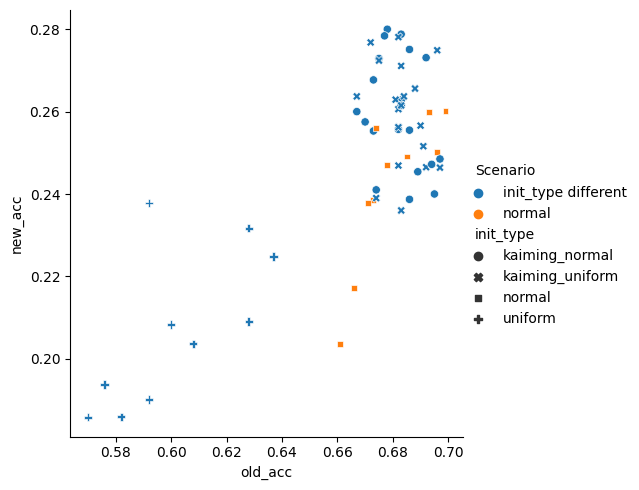

In [394]:
g = sns.relplot(
    data=a, 
    x="old_acc", 
    y="new_acc",
    hue="group", 
    style="init_type",
    legend="full",
)

g._legend.texts[0].set_text("Scenario")
g._legend.texts[1].set_text("init_type different")
g._legend.texts[2].set_text("normal")

In [392]:
g._legend.texts

[Text(0, 0, 'Scenario'),
 Text(0, 0, '4'),
 Text(0, 0, '0'),
 Text(0, 0, 'init_type'),
 Text(0, 0, 'kaiming_normal'),
 Text(0, 0, 'kaiming_uniform'),
 Text(0, 0, 'normal'),
 Text(0, 0, 'uniform')]

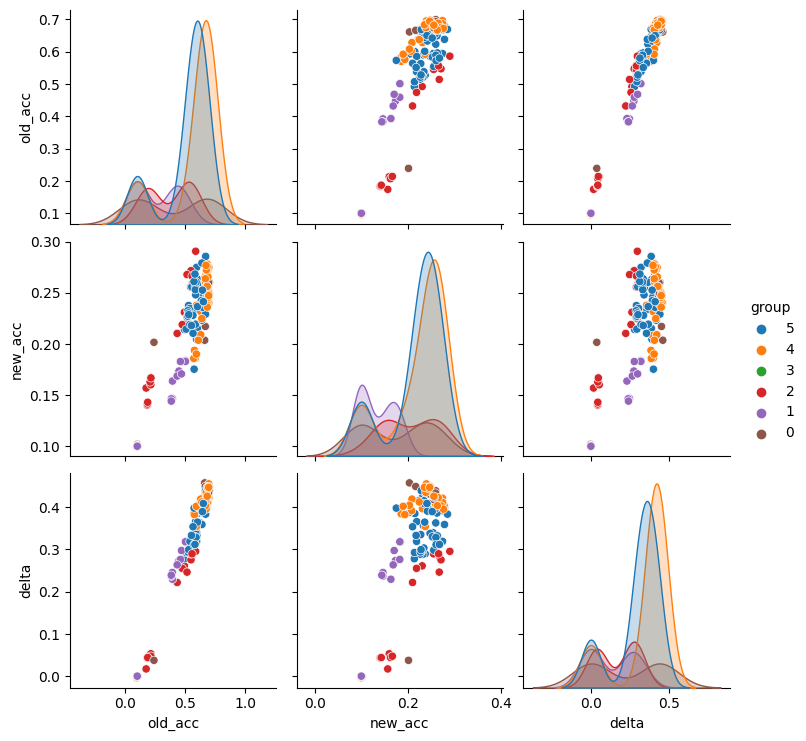

In [351]:
sns.pairplot(aux,
            vars=["old_acc", "new_acc", "delta",],
            hue="group",
             hue_order=hue_order,
            dropna=True)

In [331]:
aux[(aux.group=='4') & (aux.init_type=="kaiming_uniform") & (aux.optimizer=="sgd")]

,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta,group
161,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,4,0.935,0.682,0.247652,0.2563,0.4257,4
262,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,2,0.934,0.684,0.237173,0.2637,0.4203,4
288,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,5,0.926,0.681,0.245151,0.2629,0.4181,4
506,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,9,0.938,0.682,0.250797,0.2606,0.4214,4
584,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,1,0.936,0.682,0.243462,0.2469,0.4351,4
999,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,7,0.953,0.674,0.268595,0.2390,0.4350,4
1093,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,3,0.971,0.675,0.236868,0.2724,0.4026,4
1125,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,8,0.980,0.672,0.230884,0.2768,0.3952,4
1143,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,10,0.981,0.667,0.240166,0.2637,0.4033,4
1242,0.0,kaiming_uniform,gelu,0.001,0.9,sgd,0.001,6,0.938,0.682,0.242482,0.2562,0.4258,4


In [332]:
aux[(aux.group=='4') & (aux.init_type=="kaiming_uniform") & (aux.optimizer=="adam")]

,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta,group
279,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,10,0.929,0.683,0.229999,0.2711,0.4119,4
298,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,6,0.914,0.690,0.244904,0.2566,0.4334,4
348,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,1,0.908,0.691,0.242875,0.2516,0.4394,4
393,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,5,0.907,0.692,0.247953,0.2465,0.4455,4
446,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,4,0.903,0.697,0.259155,0.2464,0.4506,4
723,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,9,0.942,0.682,0.227553,0.2781,0.4039,4
725,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,3,0.923,0.683,0.245149,0.2615,0.4215,4
890,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,2,0.896,0.696,0.236655,0.2749,0.4211,4
1047,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,8,0.916,0.683,0.264349,0.2360,0.4470,4
1073,0.0,kaiming_uniform,gelu,0.001,0.9,adam,0.001,7,0.923,0.688,0.239531,0.2656,0.4224,4


In [164]:
aux.wd.value_counts()

0.000    110
0.001     10
0.100     10
Name: wd, dtype: int64

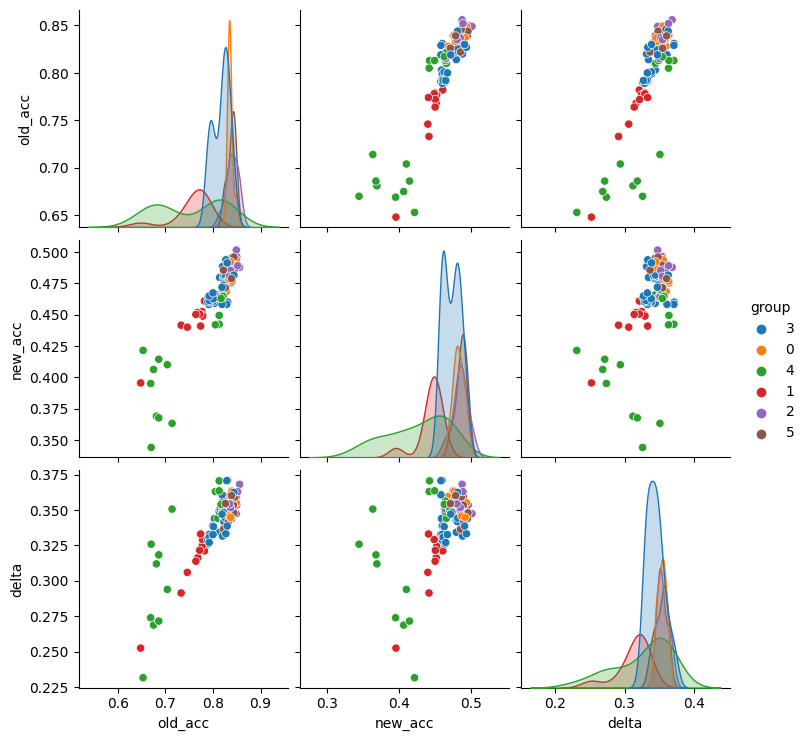

In [181]:
sns.pairplot(aux,
            vars=["old_acc", "new_acc", "delta",],
            hue="group",
            dropna=True)
#g.map_offdiag(sns.regplot)

<Axes: xlabel='old_acc', ylabel='new_acc'>

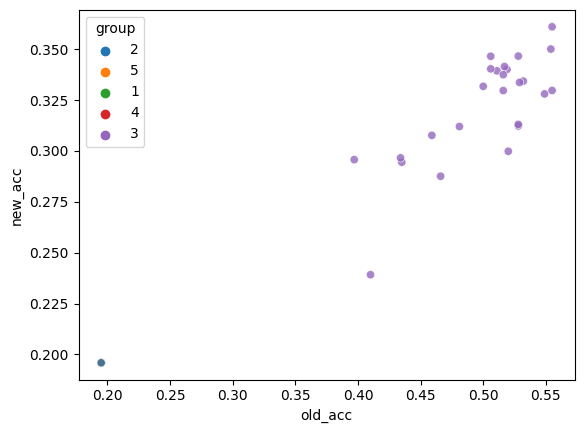

In [92]:
sns.scatterplot(aux, x="old_acc", y="new_acc", hue="group", alpha=0.8)

In [46]:
aux.wd.value_counts()

0.000    360
0.001    360
0.100    360
Name: wd, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


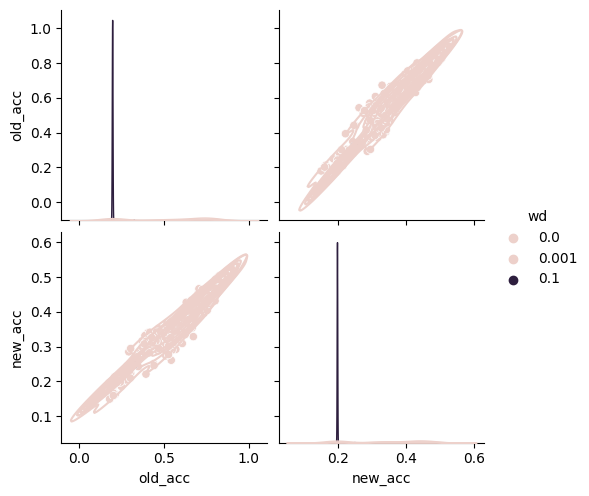

In [51]:
g = sns.pairplot(aux,
            vars=["old_acc", "new_acc"],
            hue="wd")
g.map_offdiag(sns.kdeplot, color="red")

In [48]:
type(g)

seaborn.axisgrid.PairGrid

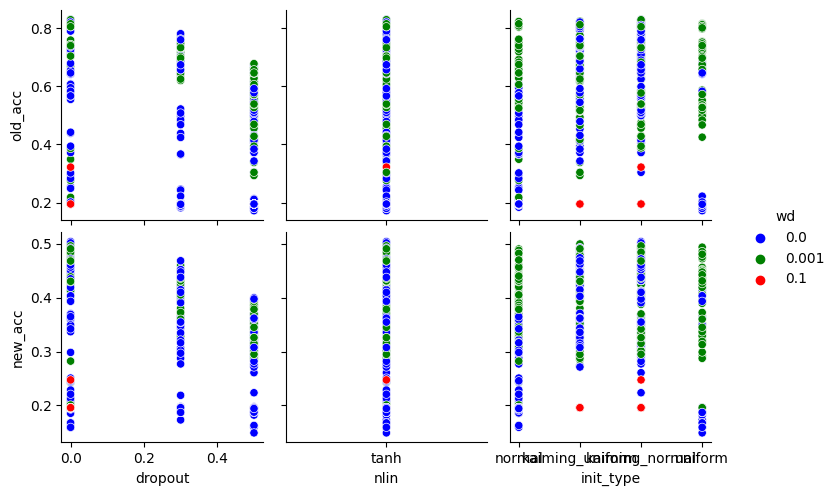

In [43]:
sns.pairplot(aux,
             y_vars=["old_acc", "new_acc"],
             x_vars=["dropout", "nlin", "init_type"],
             hue="wd",
             palette=["blue", "green", "red"])

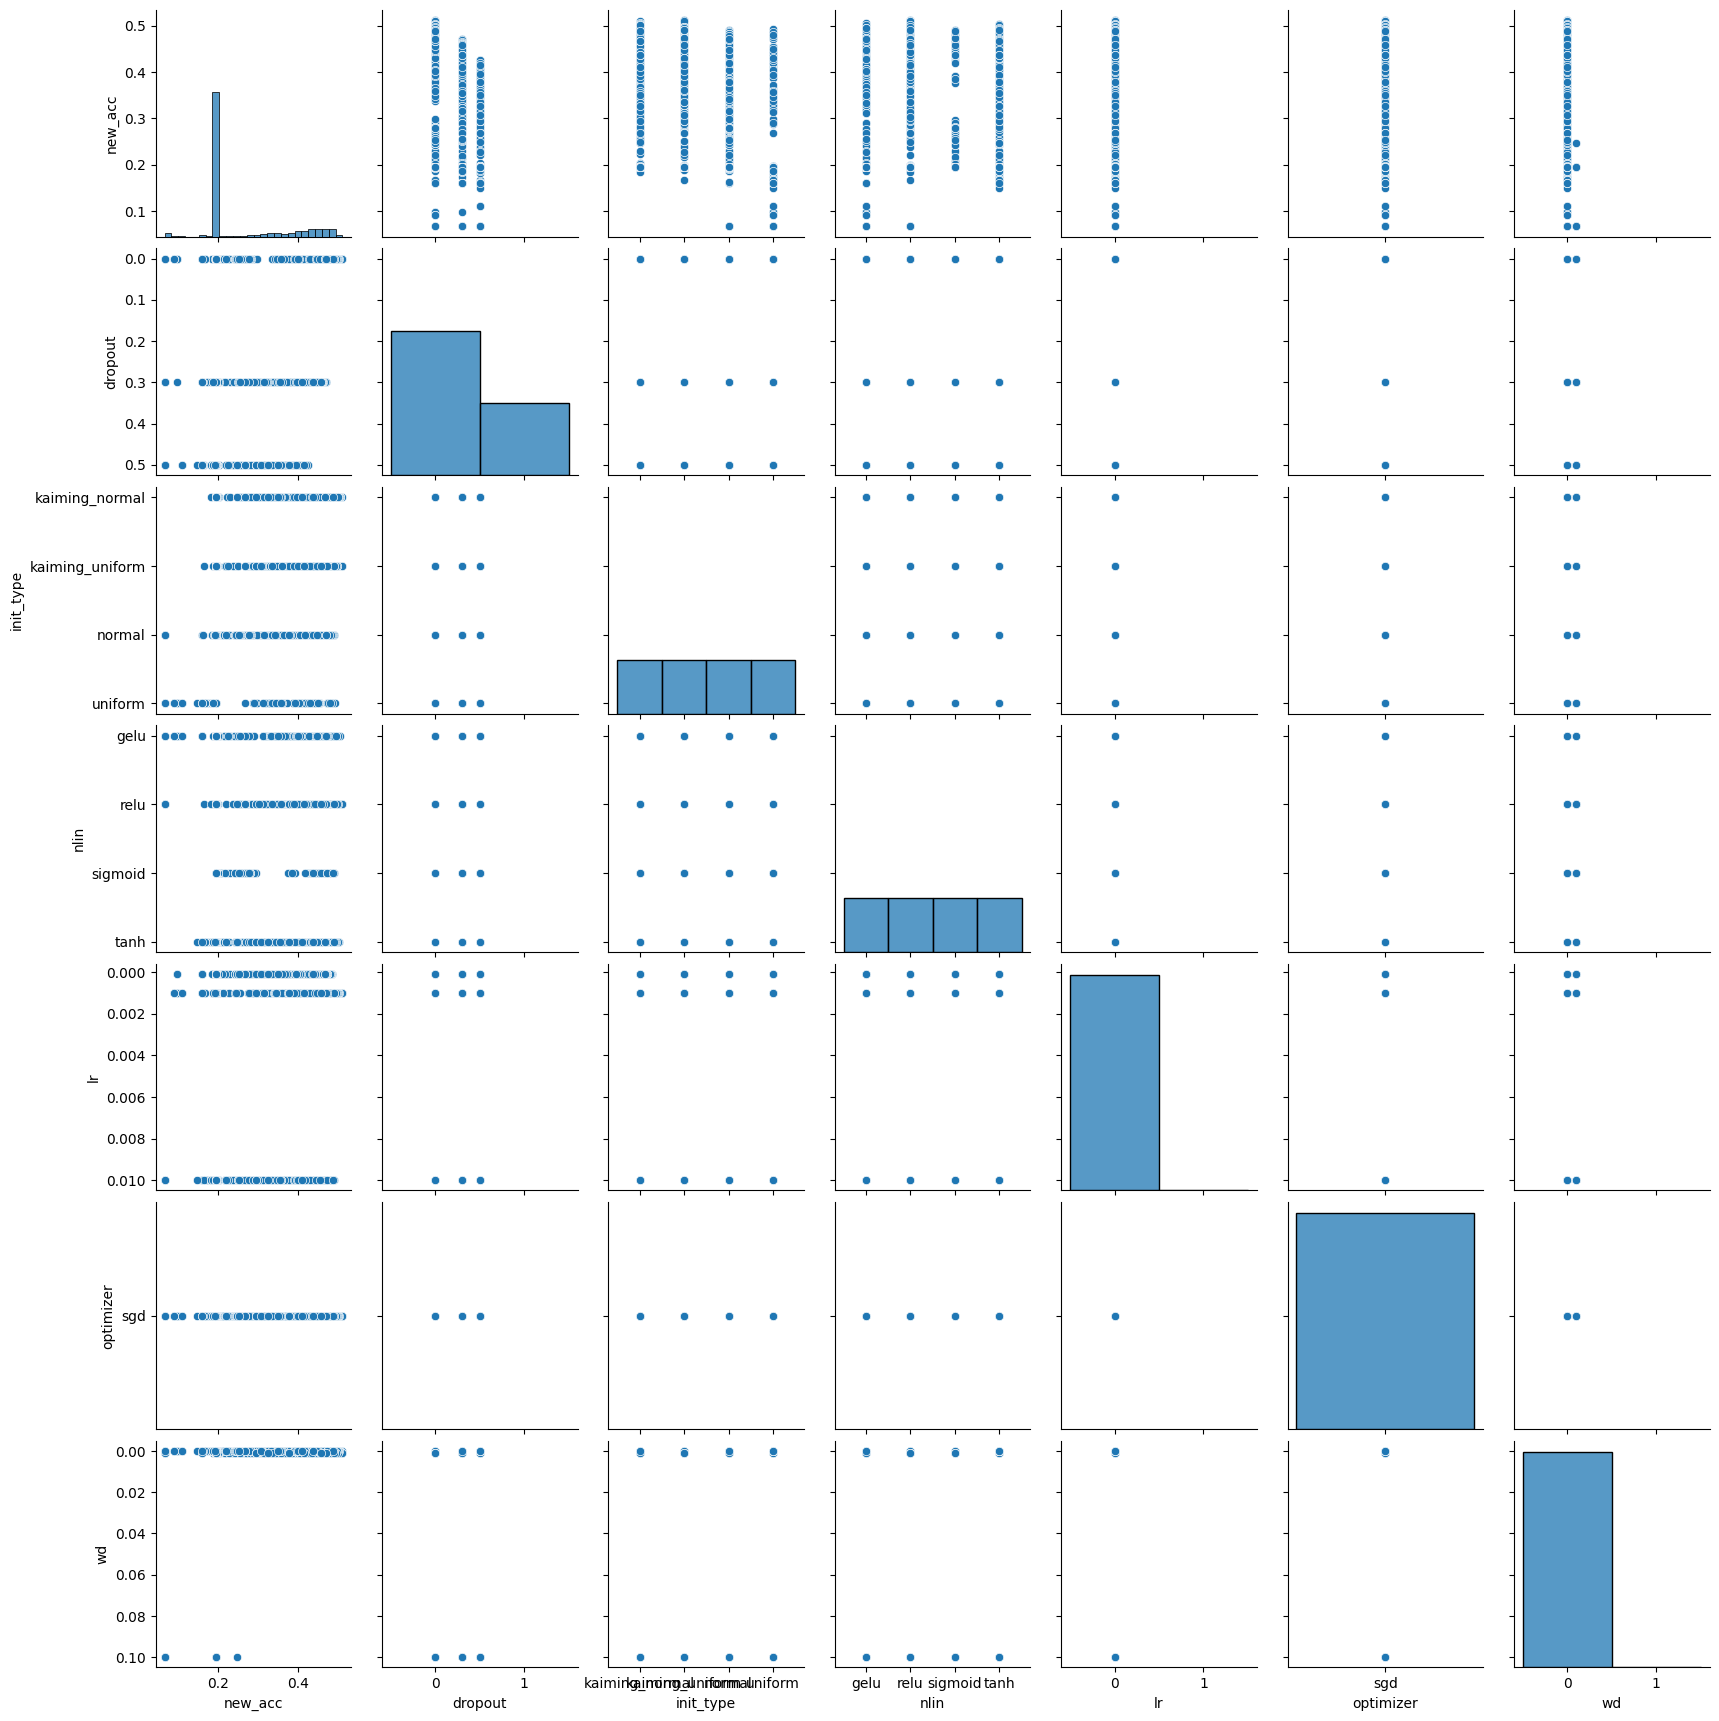

In [24]:
sns.pairplot(data[["dropout", "init_type", "nlin", "lr", "optimizer", "wd", "new_acc"]],
             vars=["new_acc", "dropout", "init_type", "nlin", "lr", "optimizer", "wd"])

In [120]:
aux.dtypes

dropout      float64
init_type     object
nlin          object
lr           float64
momentum     float64
optimizer     object
wd           float64
seed           int64
old_loss     float64
old_acc      float64
new_loss     float64
new_acc      float64
delta        float64
group         object
dtype: object